<a href="https://colab.research.google.com/github/Cristina-Mercado/my-project/blob/master/Build_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código para estructurar y preparar el dataset de Daily Dialog mediante los tres formatos planteados (por pares de intervenciones, con historia con emociones y con historia sin emociones).

Imports:

In [ ]:
! pip install pandas

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

Acceso a los archivos en mi Drive Personal (cambiar el path hasta el sitio de descarga):

In [ ]:
drive.mount('/content/drive')
%cd drive/MyDrive/ETSII/4_Cuarto/TFG/Colab_Notebooks

In [ ]:
!pip install datasets

# Daily Dialog dataFrame

In [ ]:
DDMain = pd.read_csv('DAILYD_main.csv')  #skipinitialspace=True
DDInfo = pd.read_csv('DAILYD_dialoginfo.csv')

In [ ]:
DDMain

Adding 'emotion' column to Main dataFrame:

In [ ]:
DDMain['emotion']=DDInfo['emotion']

Adding a 'dialog' column to Main dataFrame:

In [ ]:
length = DDMain["SEG"].size

In [ ]:
list=[]
str="D"
for j in range (0, length):
  for i in range (7,13):
    str = str + DDMain['UID'][j:j+1][j][i]
  list.append(str)
  str="D"

In [ ]:
DDMain['dialog']=list

Renaming 'SID' and 'SEG' columns:

In [ ]:
del DDMain['UID']

In [ ]:
DDMain = DDMain.rename(columns={'SID':'speaker', 'SEG':'text'})

In [ ]:
DDMain

In [ ]:
DDMain['text'][5:15]

## Build inputs

### Functions

Funciones:
* build_inputs_pair: estructura el conjunto de datos por pares de intervenciones de la forma: <bos><etiqueta> *texto* <sep><etiqueta respuesta> *texto (respuesta)* <eos>
* build_inputs_history: estructura el conjunto de datos incluyendo una historia de 3 intervenciones más una respuesta de la forma: <bos><etiqueta 1> *texto 1* <etiqueta 2> *texto 2* <etiqueta 3> *texto 3* <sep><etiqueta respuesta> *texto (respuesta)* <eos>
* build_inputs_one_emotion: estructura el conjunto de datos incluyendo una historia de 3 intervenciones sin etiquetas más una respuesta con etiqueta, de la forma: <bos>*texto 1* *texto 2* *texto 3* <sep><etiqueta respuesta> *texto (respuesta)* <eos>

In [ ]:
def build_inputs_pair(dialog, emotion, text):
  global data
  global prev_dialog
  global i, k

  # Si la anterior conversación tenía intervenciones impares
  # Borramos la última intervención y comenzamos una nueva pareja
  if k==1 and dialog!=prev_dialog:
    data.pop()
    k=0

  # Inicio del par de intervenciones:
  if k==0:
    data.append('<bos>')
    data[i] += emotion
    data[i] += text + '<sep>'
    k = 1
    prev_dialog = dialog
  # Respuesta:
  else:
      data[i] += emotion + text + '<|endoftext|>'
      i += 1
      k = 0
 

In [ ]:
def build_inputs_history(dialog, emotion, text):
  global data
  global prev_dialog
  global i, k

  if dialog == prev_dialog:
    if k<3 and len((emotion + text + data[i]).split())<300: 
      data[i] = emotion + text + data[i]
      k += 1
    else:
      data[i] = '<bos>' + data[i]
      data.append('<eos>')
      i += 1
      data[i] = '<sep>' + emotion + text + data[i]
      k = 0 
  else:  
    # Si no es la primera intervención
    if i != -1:
      data[i] = '<bos>' + data[i]
      # Si la última vez se ha creado un input sin historia
      if k == 0:
        data.pop()
        i -= 1 
      data.append('<eos>') 
    i += 1 
    prev_dialog = dialog
    data[i] = '<sep>' + emotion + text + data[i]
    k = 0 
    

In [ ]:
def build_inputs_one_emotion(dialog, emotion, text):

  global data
  global prev_dialog
  global i, k

  if dialog == prev_dialog:
    if k<3 and len((text + data[i]).split())<300: 
      data[i] = " " + text + data[i]
      k += 1
    else:
      data[i] = '<bos>' + data[i]
      data.append('<eos>')
      i += 1
      data[i] = '<sep>' + emotion + text + data[i]
      k = 0 
  else:  
    # Si no es la primera intervención
    if i != -1:
      data[i] = '<bos>' + data[i]
      # Si la última vez se ha creado un input sin historia
      if k == 0:
        data.pop()
        i -= 1 
      data.append('<eos>') 
    i += 1 
    prev_dialog = dialog
    data[i] = '<sep>' + emotion + text + data[i]
    k = 0 

### Apply functions

Creación de listas con la estructura aplicada al conjunto y tranformación en dataFrame

In [ ]:
data=[]
i=0
k=0
length = len(DDMain['text'])

for j in range(0,length):
  dialog = DDMain['dialog'][j]
  emotion = '<' + DDMain['emotion'][j] + '>'
  text = DDMain['text'][j]
  build_inputs_pair(dialog, emotion, text)

In [ ]:
MainDD_pairs_dict = {'text':data}
MainDD_pairs = pd.DataFrame(MainDD_pairs_dict)

In [ ]:
data=['<eos>']
i=-1
prev_dialog=0
length = len(DDMain['text'])

for j in range(length-1, -1, -1):
  dialog = DDMain['dialog'][j]
  emotion = '<' + DDMain['emotion'][j] + '>'
  text = DDMain['text'][j]
  build_inputs_history(dialog, emotion, text)

data[i] = '<bos>' + data[i]

In [ ]:
MainDD_history_dict = {'text':data}
MainDD_history = pd.DataFrame(MainDD_history_dict)

In [ ]:
data=['<eos>']
i=-1
prev_dialog=0
length = len(DDMain['text'])

for j in range(length-1, -1, -1):
  dialog = DDMain['dialog'][j]
  emotion = '<' + DDMain['emotion'][j] + '>'
  text = DDMain['text'][j]
  build_inputs_one_emotion(dialog, emotion, text)

data[i] = '<bos>' + data[i]

In [ ]:
MainDD_oneEmo_dict= {'text':data}
MainDD_oneEmo = pd.DataFrame(MainDD_oneEmo_dict)

### Normalization

Homogeneización de símbolos y eliminación de espacios al inicio y final de las intervenciones.

In [ ]:
MainDD_pairs['text'] = MainDD_pairs['text'].str.replace(' ’ ',"'")

In [ ]:
MainDD_history['text'] = MainDD_history['text'].str.replace(' ’ ',"'")

In [ ]:
MainDD_oneEmo['text'] = MainDD_oneEmo['text'].str.replace(' ’ ',"'")

In [ ]:
MainDD_pairs['text'] = MainDD_pairs['text'].str.replace('> ','>')
MainDD_pairs['text'] = MainDD_pairs['text'].str.replace(' <','<')

In [ ]:
MainDD_history['text'] = MainDD_history['text'].str.replace('> ','>')
MainDD_history['text'] = MainDD_history['text'].str.replace(' <','<')

In [ ]:
MainDD_oneEmo['text'] = MainDD_oneEmo['text'].str.replace('> ','>')
MainDD_oneEmo['text'] = MainDD_oneEmo['text'].str.replace(' <','<')

### Shuffle

In [ ]:
# Mezcla:
MainDD_pairs_shuffled = MainDD_pairs.sample(frac=1)
# Reorganización de los índices:
MainDD_pairs_shuffled.index = range(MainDD_pairs_shuffled.shape[0])

### Smaller dataset for testing

In [ ]:
SmallDD_data=data[0:400]
SmallDD_dict={'text':SmallDD_data}
SmallDD_df=pd.DataFrame(SmallDD_dict)

##  Download as csv

In [ ]:
MainDD_pairs.to_csv('DD_pairs.csv')
MainDD_history.to_csv('DD_history.csv')
MainDD_oneEmo.to_csv('DD_oneEmotion.csv')

In [ ]:
MainDD_pairs_shuffled.to_csv('DD_pairs_shuffled.csv')

División del dataset en 80% training data y 20% testing data, sin mezclar.

In [ ]:
train, test = train_test_split(MainDD_df, test_size=0.2, shuffle=False)

In [ ]:
train.index = range(train.shape[0])
test.index = range(test.shape[0])

In [ ]:
train.to_csv('ShuffledTrainData.csv', index=False)
test.to_csv('ShuffledTestData.csv', index=False)

Smaller dataset:

In [ ]:
train_small, test_small = train_test_split(SmallDD_df, test_size=0.2, shuffle=False)

In [ ]:
train_small.to_csv('SmallTrainData.csv', index=False)
test_small.to_csv('SmallTestData.csv', index=False)

# Data augmentation

Dada la distribución de las etiquetas en DailyDialog y asumiendo que en EmotionLines es similar, se trata de elevar la cantidad de las menos frecuentes a un nivel comparable con el de happiness.

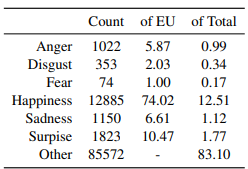

Para ello se multiplican los inputs que contengan 'surprise', 'sadness' y 'anger' por 10, 'disgust' por 20 y 'fear' por 30.

In [ ]:
DDMain = pd.read_csv('BuiltData.csv')

In [ ]:
del DDMain['Unnamed: 0']

In [ ]:
max = 0
length = len(DDMain)
for i in range (0,length-1):
  if len(DDMain['text'][i].split()) > max:
    max = len(DDMain['text'][i].split())
print(max)

In [ ]:
train, test = train_test_split(DDMain, test_size=0.15, shuffle=True)

In [ ]:
train.index = range(train.shape[0])
test.index = range(test.shape[0])

In [ ]:
len(train)

In [ ]:
print(len(train[train.text.str.contains("happiness")]))
print(len(train[train.text.str.contains("surprise")]))
print(len(train[train.text.str.contains("sadness")]))
print(len(train[train.text.str.contains("anger")]))
print(len(train[train.text.str.contains("disgust")]))
print(len(train[train.text.str.contains("fear")]))

In [ ]:
replication = []
for i in range (0, 3):
  replication.extend(train['text'][train.text.str.contains("surprise")])
for i in range (0, 6):
  replication.extend(train['text'][train.text.str.contains("sadness")])
  replication.extend(train['text'][train.text.str.contains("anger")])
for i in range (0, 8): #18 
  replication.extend(train['text'][train.text.str.contains("disgust")])
for i in range (0, 10): #24
  replication.extend(train['text'][train.text.str.contains("fear")])

In [ ]:
replication_dict = {'text':replication}
replication_df = pd.DataFrame(replication_dict)

In [ ]:
len(replication_df)

19258

In [ ]:
len(replication_df[replication_df.text.str.contains("disgust")])

2299

In [ ]:
train_aum = pd.concat([train, replication_df])
train_aum = train_aum.sample(frac=1)
train_aum.index = range(train_aum.shape[0])

In [ ]:
train_aum.to_csv('DD_pairs_shuffled_aum_train2.csv')
test.to_csv('DD_pairs_shuffled_aum_test2.csv')